In [5]:
import math

import ConnectionNetworkX_v2 as cnx
import numpy as np
import networkx as nx
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm


# Solving the Beckmann problem on a grid graph, i.e., pixel space.

Initialize the grid graph

In [6]:

GRID_WIDTH = 32
GRID_HEIGHT = 32
INTRINSIC_DIM = 3

gridGraph = cnx.cnxFromPixelGrid(GRID_WIDTH, GRID_HEIGHT, INTRINSIC_DIM)

gridGraphIncidenceMatrix = gridGraph.B


Generate the constraint matrices and densities to be transported. Example seen here is dirac densities at corners of the grid.

In [7]:
import imageio

def localizedColorDensity(grid, centerInEmbeddingSpace, normalizedRGBValues, radiusInCanonicalEmbeddingSpace):

    RGB_DIM = 3

    x0, y0 = centerInEmbeddingSpace

    density = np.zeros((gridGraph.number_of_nodes(), RGB_DIM))#.flatten()[:,None]

    # In order for it to be a valid density we need to add some ambient color so the row sum is positive everywhere
    uniformNoise = (1 - normalizedRGBValues) / grid.number_of_nodes()

    for node in tqdm(grid.nodes):

        x, y = grid.gridEmbedding[node]

        d = ((x - x0) ** 2 + (y - y0) ** 2) ** 0.5

        if d <= radiusInCanonicalEmbeddingSpace:
            #alpha = math.exp(- math.log(4) * d / radiusInCanonicalEmbeddingSpace)
            alpha = 1 - d / radiusInCanonicalEmbeddingSpace
            scaledRGB = (alpha) * normalizedRGBValues
        else:
            scaledRGB = np.array([0, 0, 0])

        density[node, :] = scaledRGB + uniformNoise

    s = np.sum(density, axis=0)
    for dim in range(RGB_DIM):
        density[:, dim] /= s[dim]

    density = density.flatten()

    return density

def colorDensityFromImage(grid, path, RGB_DIM = 3):

    image = imageio.v3.imread(path) / 255
    density = np.zeros((gridGraph.number_of_nodes(), RGB_DIM))

    uniformNoise = np.ones((1, RGB_DIM)) / grid.number_of_nodes()

    print("Processing image density ... ")

    for node in tqdm(grid.nodes):

        x, y = grid.gridEmbedding[node]
        j, i = min(math.floor(image.shape[0] * (x)), image.shape[0]-1), min(math.floor(image.shape[1] * (1-y)), image.shape[1] - 1)

        density[node, :] = np.array(image[i, j]) + uniformNoise

    s = np.sum(density, axis=0)
    print(s)
    for dim in range(RGB_DIM):
        density[:, dim] /= s[dim]

    density = density.flatten()

    return density

def renderColorDensityAsImage(grid, localizedColorDensity):

    localizedColorDensity /= np.max(localizedColorDensity)

    fig, ax = plt.subplots()
    embedding = grid.gridEmbedding
    RGB_DIM = 3

    ax.set_xlim((0, 1 + 1/GRID_WIDTH))
    ax.set_ylim((0, 1 + 1/GRID_HEIGHT))

    for node in tqdm(list(range(gridGraph.number_of_nodes()))):

        center = embedding[node][0], embedding[node][1]

        rgb = localizedColorDensity[(node * RGB_DIM) : ((node + 1) * RGB_DIM)]
        colorRGB = rgb.tolist() + [1]

        nodeLabel = matplotlib.patches.Rectangle(center, 1/GRID_WIDTH, 1/GRID_HEIGHT, color=colorRGB)
        ax.add_patch(nodeLabel)

    plt.show()

Processing image density ... 


100%|██████████| 1024/1024 [00:00<?, ?it/s]


[ 934.97647059  947.96078431 1023.99215686]
Processing image density ... 


100%|██████████| 1024/1024 [00:00<?, ?it/s]


[ 928.84313725  942.64313725 1024.27843137]


100%|██████████| 1024/1024 [00:00<00:00, 3170.69it/s]


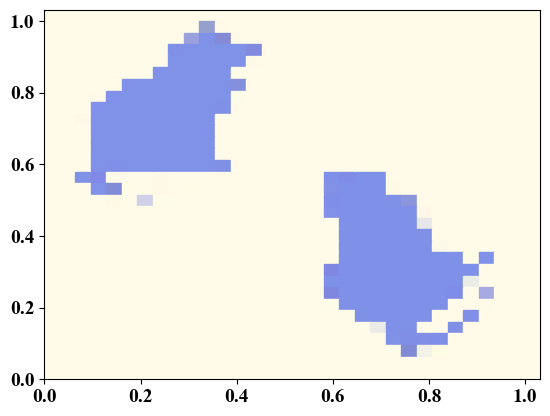

In [8]:

cat = colorDensityFromImage(gridGraph, 'data/blue_cat.jpg')
horse = colorDensityFromImage(gridGraph, 'data/blue_cat_2.jpg')

renderColorDensityAsImage(gridGraph, cat + horse)


In [9]:
cat

array([0.00107059, 0.00105593, 0.00097752, ..., 0.00107059, 0.00105593,
       0.00097752])

In [10]:
(cat + horse) / np.max(cat + horse) * 255

array([255.        , 251.38666423, 232.03421721, ..., 255.        ,
       251.38666423, 232.03421721])

In [11]:
import torch
import time

t0 = time.time()

c = cat - horse
c.reshape((gridGraph.number_of_nodes(), INTRINSIC_DIM))
c = torch.tensor(c)

t1 = time.time()
print("time to init c: ", t1 - t0)

B = torch.tensor(gridGraphIncidenceMatrix.toarray())
w = torch.tensor(np.array([edge[2]['weight'] for edge in gridGraph.edges(data=True)]).astype('float32'))

t2 = time.time()
print("time to init B, w: ", t2 - t1)

#initialPhi = -np.matmul(np.linalg.pinv(np.matmul(B, B.T)), c)
initialPhi = -np.matmul(sp.linalg.pinvh(np.matmul(B, B.T)), c)

t3 = time.time()
print("time to init initPhi: ", t3-t2)

time to init c:  0.0
time to init B, w:  0.1120450496673584
time to init initPhi:  6.251345872879028


In [12]:
learning_rate = 5e-3
alpha = 1
n_epochs = 10000

gridPhi = cnx.optimize(B.T, w, c, alpha, learning_rate, n_epochs, phi0=initialPhi)

epoch: 0, loss: 0.003834, loss0: 0.003834, loss1: 0.000000


C:\Users\Sawyer\Documents\IdeaProjects\connection-graph-wasserstein\ConnectionNetworkX_v2.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi0, requires_grad=True)


epoch: 10, loss: -0.015208, loss0: -0.015208, loss1: 0.000000
epoch: 20, loss: -0.034250, loss0: -0.034250, loss1: 0.000000
epoch: 30, loss: -0.053291, loss0: -0.053291, loss1: 0.000000
epoch: 40, loss: -0.072333, loss0: -0.072333, loss1: 0.000000
epoch: 50, loss: -0.091375, loss0: -0.091375, loss1: 0.000000
epoch: 60, loss: -0.110417, loss0: -0.110417, loss1: 0.000000
epoch: 70, loss: -0.129459, loss0: -0.129459, loss1: 0.000000
epoch: 80, loss: -0.147585, loss0: -0.147601, loss1: 0.000031
epoch: 90, loss: -0.165656, loss0: -0.165671, loss1: 0.000030
epoch: 100, loss: -0.183706, loss0: -0.183711, loss1: 0.000011
epoch: 110, loss: -0.201355, loss0: -0.201389, loss1: 0.000069
epoch: 120, loss: -0.218923, loss0: -0.218965, loss1: 0.000084
epoch: 130, loss: -0.236624, loss0: -0.236633, loss1: 0.000019
epoch: 140, loss: -0.254239, loss0: -0.254250, loss1: 0.000020
epoch: 150, loss: -0.271679, loss0: -0.271768, loss1: 0.000178
epoch: 160, loss: -0.288875, loss0: -0.288918, loss1: 0.000086
e

# Visualizing the Soln. to the Connection Beckmann Problem on a Grid

In [13]:
regularizedActiveEdges = cnx.active_edges(gridPhi, B.T, w, c).detach().numpy()
#regularizedEdgeFlows = torch.matmul(B.T, gridPhi).detach().numpy()
regularizedEdgeFlows =  cnx.optimal_J(gridPhi, B.T, w, alpha, INTRINSIC_DIM).detach().numpy()
regularizedEdgeFlows = regularizedEdgeFlows.flatten()

#mask = (regularizedActiveEdges > 0)
#regularizedEdgeFlows[mask, :] /= regularizedActiveEdges[mask][:, np.newaxis]/alpha
#regularizedEdgeFlows = ((1 + regularizedEdgeFlows )/ 2).flatten()


In [14]:
J = cnx.optimal_J(gridPhi, B.T, w, alpha, INTRINSIC_DIM)

np.linalg.norm(torch.matmul(B, J.flatten()).detach().numpy() - c.detach().numpy())


0.04874619416253027

100%|██████████| 1024/1024 [00:00<00:00, 2708.30it/s]


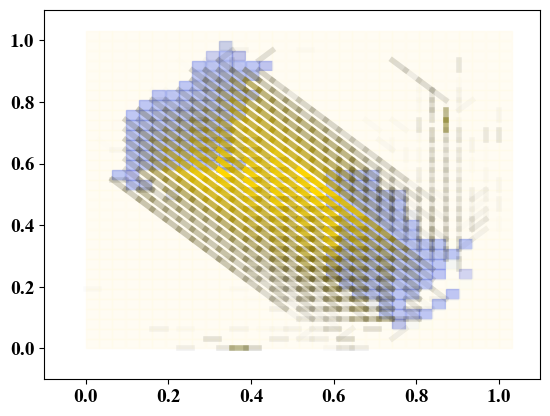

In [18]:
spectralEmbedding = gridGraph.gridEmbedding

TOLERANCE = 0 # 1.5e-3
MAX = np.max(regularizedActiveEdges)

fig, ax = plt.subplots()
ax.set_xlim((-.1, 1.1))
ax.set_ylim((-.1, 1.1))

for node in tqdm(list(range(gridGraph.number_of_nodes()))):

    center = spectralEmbedding[node][0], spectralEmbedding[node][1]

    localizedColorDensity = cat + horse

    INTENSITY = 1 / np.max(cat + horse)

    colorRGB = (INTENSITY*( localizedColorDensity[(node * 3) : ((node + 1) * 3)])).tolist() + [.5]

    nodeLabel = matplotlib.patches.Rectangle(center, 1/GRID_WIDTH, 1/GRID_HEIGHT, color=colorRGB)
    ax.add_patch(nodeLabel)

    # col = "tab:blue" # phi[(node * INTRINSIC_DIM) : ((node + 1) * INTRINSIC_DIM) ].tolist() + [1]  #"tab:blue"
    # zNode=4
    # r=1e-3
    # nodeLabel = matplotlib.patches.Circle(center, radius=r, color=col, zorder=zNode)
    #
    # ax.add_patch(nodeLabel)

for edgeIndex, edge in zip(range(gridGraph.number_of_edges()), list(gridGraph.edges())):

    m = np.max(abs(regularizedEdgeFlows))

    if regularizedActiveEdges[edgeIndex] > TOLERANCE:

        flow = np.copy(regularizedEdgeFlows[(edgeIndex * INTRINSIC_DIM) : ((edgeIndex + 1) * INTRINSIC_DIM) ])

        flow /= m #Boundary noise values- check if they are
        #flow %= 1.0
        flow = flow.tolist()
        flow = [ x - 1 if x > 1 else -x if x < 0 else x for x in flow ]


        alpha = abs(regularizedActiveEdges[edgeIndex])/MAX
        col= flow  +  [alpha] #(1, 0, 0, alpha) #flow + [alpha] #(1, 0, .1, abs(regularizedActiveEdges[edgeIndex])/MAX)
        z = 3
        lw = 4

    else:
        #col="tab:blue"
        lw=0.5
        col=(1,1,1,0)
        z = 3

    # if edgeIndex==1929:
    #     col = [1, 0, 0, 1]

    fromNode = edge[0]
    toNode = edge[1]
    centerFromNode = spectralEmbedding[fromNode][0], spectralEmbedding[fromNode][1]
    centerToNode = spectralEmbedding[toNode][0], spectralEmbedding[toNode][1]

    ax.plot((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), color=col, lw=lw)


plt.show()

# xData, yData = spectralEmbedding.values

In [16]:
a = np.copy(regularizedEdgeFlows[5787:5790])
# print(a)
# a = abs(a)
# a /= np.max(a)
# print(a)
# a = a.tolist()
# a = [np.min([abs(x), 1]) for x in a]

m = np.max(abs(regularizedEdgeFlows))
a /= m
a % 1.0

array([0.21810463, 0.33839207, 0.99608967])

In [17]:
|import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

np.where(regularizedActiveEdges > 0)

SyntaxError: invalid syntax (4047208070.py, line 1)